# Modeling |  Modeling Spotify track popularity
## Leo Evancie, Springboard Data Science Career Track

This is the fourth step in a capstone project to model music popularity on Spotify, a popular streaming service. Further project details and rationale can be found in the document 'Proposal.pdf'.

In this notebook, I will apply my cleaned and processed data to a number of models. For each type of model, I will perform hyperparameter tuning with cross-validation. Ultimately, I will determine which model performs best in predicting whether a given track is popular on Spotify.

First, I will read in the data, already split into train and test chunks from the preprocessing stage:

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score

In [2]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
y_train = np.ravel(pd.read_csv('../data/y_train.csv', index_col=0))
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_test = np.ravel(pd.read_csv('../data/y_test.csv', index_col=0))

In [3]:
# Reminder of the training data features
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6896 entries, 9671 to 2191
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   single            6896 non-null   int64  
 1   danceability      6896 non-null   float64
 2   energy            6896 non-null   float64
 3   instrumentalness  6896 non-null   float64
 4   explicit          6896 non-null   int64  
 5   collab            6896 non-null   int64  
 6   timesig_0         6896 non-null   int64  
 7   timesig_1         6896 non-null   int64  
 8   timesig_3         6896 non-null   int64  
 9   timesig_4         6896 non-null   int64  
 10  timesig_5         6896 non-null   int64  
 11  duration_s        6896 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 700.4 KB


### Logistic regression

Baseline model first:

In [4]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
# Generate predictions from training data for training scores
y_train_pred = lr.predict(X_train)
# Save baseline f1 training score for comparison to testing & tuned scores
lr_baseline_f1_train = f1_score(y_train, y_train_pred)
print('Baseline LR classification report (training):\n')
print(classification_report(y_train, y_train_pred))

Baseline LR classification report (training):

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      3558
           1       0.75      0.69      0.72      3338

    accuracy                           0.74      6896
   macro avg       0.74      0.74      0.74      6896
weighted avg       0.74      0.74      0.74      6896



In [5]:
# Generate predictions from testing data for testing scores
y_test_pred = lr.predict(X_test)
lr_baseline_f1_test = f1_score(y_test, y_test_pred)
print('Basline LR classification report (testing):\n')
print(classification_report(y_test, y_test_pred))

Basline LR classification report (testing):

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1509
           1       0.76      0.70      0.73      1447

    accuracy                           0.74      2956
   macro avg       0.75      0.74      0.74      2956
weighted avg       0.75      0.74      0.74      2956



With a simple baseline logistic regression model, I see an f1 test score of 0.73. With similar scores for training and testing, we do not see evidence of overfit.

Now, I will tune hyperparameters. The most straightforward method of hyperparameter tuning is grid search with cross-validation. We provide a set of values for any or all model parameters, and the GridSearchCV object systematically tests every possible combination of those given parameters (i.e., it steps through a multidimensional 'grid' of parameter values).

The 'CV' in GridSearchCV stands for cross-validation, which is a useful method to stave off overfitting. GridSearchCV applies cross-validation at each step of the grid search. The training data is split into k "folds", or equally-sized chunks (the default value for k is 3 in the case of GridSearchCV, but it can be altered). A model is trained from the current set of parameters, and then the model is fit to k-1 folds, leaving the kth aside to act as a test set. A model score is produced and saved. Then, a new model is fit to a different set of k-1 folds (using the same current set of parameters from the grid search), using a different chunk as the test set, producing a second score. This process is performed a total of k times, each iteration using a different chunk as the holdout set, until we have k scores. Those scores are then averaged. This provides us with a score corresponding to a certain set of parameters, and we can be more confident in this score, because the cross-validation lowers the chances that our score was impacted too much by the incidental nature of our overall train/test split. We have, in a sense, simulated the train-test split k times, without ever exposing the model to the real test data.

Here, I will only test a range of regularization parameters, along with a random state for the sake of reproducability.

In [6]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100,],
    'random_state':[42]
}

lr = LogisticRegression()
lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid)
lr_grid.fit(X_train, y_train)
lr_grid.best_params_

{'C': 10, 'random_state': 42}

In [7]:
y_train_pred = lr_grid.predict(X_train)
lr_tuned_f1_train = f1_score(y_train, y_train_pred)
print('Tuned LR classification report (training):')
print(classification_report(y_train, y_train_pred))

Tuned LR classification report (training):
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      3558
           1       0.75      0.69      0.72      3338

    accuracy                           0.74      6896
   macro avg       0.74      0.74      0.74      6896
weighted avg       0.74      0.74      0.74      6896



In [8]:
y_test_pred = lr_grid.predict(X_test)
lr_tuned_f1_test = f1_score(y_test, y_test_pred)
print('Tuned LR classification report (testing):')
print(classification_report(y_test, y_test_pred))

Tuned LR classification report (testing):
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1509
           1       0.76      0.70      0.73      1447

    accuracy                           0.74      2956
   macro avg       0.74      0.74      0.74      2956
weighted avg       0.74      0.74      0.74      2956



In [9]:
print('Change in LR f1 score from parameter tuning:', round(lr_tuned_f1_test-lr_baseline_f1_test, 3))

Change in LR f1 score from parameter tuning: 0.001


There was barely any improvement, which is not entirely unexpected given the fact that I only tested a small number of values for one single parameter.

### K-nearest neighbors

Baseline model:

In [10]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
knn_baseline_f1_train = f1_score(y_train, y_train_pred)
print('Baseline KNN classification report (training):')
print(classification_report(y_train, y_train_pred))

Baseline KNN classification report (training):
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3558
           1       0.81      0.88      0.84      3338

    accuracy                           0.84      6896
   macro avg       0.84      0.84      0.84      6896
weighted avg       0.84      0.84      0.84      6896



In [11]:
y_test_pred = knn.predict(X_test)
knn_baseline_f1_test = f1_score(y_test, y_test_pred)
print('Baseline KNN classification report (testing):')
print(classification_report(y_test, y_test_pred))

Baseline KNN classification report (testing):
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1509
           1       0.73      0.81      0.77      1447

    accuracy                           0.76      2956
   macro avg       0.77      0.77      0.76      2956
weighted avg       0.77      0.76      0.76      2956



The baseline KNN model displayed some overfitting.

Next, I will tune parameters by performing a grid search over a range of numbers of neighbors, as well as uniform vs. distance-based weights:

In [12]:
param_grid = {
    'n_neighbors': [1,3,5,7,9],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn, param_grid=param_grid)
knn_grid.fit(X_train, y_train)
knn_grid.best_params_

{'n_neighbors': 9, 'weights': 'distance'}

In [14]:
y_train_pred = knn_grid.predict(X_train)
knn_tuned_f1_train = f1_score(y_train, y_train_pred)
print('Tuned KNN classification report (training):')
print(classification_report(y_train, y_train_pred))

Tuned KNN classification report (training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3558
           1       1.00      1.00      1.00      3338

    accuracy                           1.00      6896
   macro avg       1.00      1.00      1.00      6896
weighted avg       1.00      1.00      1.00      6896



In [15]:
y_test_pred = knn_grid.predict(X_test)
knn_tuned_f1_test = f1_score(y_test, y_test_pred)
print('Tuned KNN classification report (testing):')
print(classification_report(y_test, y_test_pred))

Tuned KNN classification report (testing):
              precision    recall  f1-score   support

           0       0.81      0.73      0.76      1509
           1       0.74      0.82      0.78      1447

    accuracy                           0.77      2956
   macro avg       0.77      0.77      0.77      2956
weighted avg       0.77      0.77      0.77      2956



In [16]:
print('Change in f1 score from parameter tuning:', round(knn_tuned_f1_test-knn_baseline_f1_test, 3))

Change in f1 score from parameter tuning: 0.006


The model has memorized our training data, producing 100% training scores. With an f1 test score of 0.78, though, the tuned KNN performed a little better than the tuned LR model.

Logistic regression and k-nearest neighbors are each single models, where classification is determined by a single calculation, and that calculation is shaped by the parameters the model learns from the training data. Such models can perform quite well under many circumstances. But we can also employ "ensemble models", which produce a large group of similarly-structured models, all of which get a say in the final classification decision. Ensemble models are shown to be more robust, because while a given individual model in the ensemble may produce a bias in a certain direction, another model will likely produce bias of a similar magnitude in the opposite direction. With enough members in the ensemble, the bias gets smoothed out.

### Random Forest

Random forests are a popular ensemble model, where several decision trees are trained on bootstrapped samples from the training data. Classification is determined by a survey of decisions from the resulting "forest" of individual trees. In order to set a baseline, I will first create a random forest with all default parameters (setting the random state for reproducability).

In [17]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
rfc_baseline_f1_train = f1_score(y_train, y_train_pred)
print('Baseline RFC classification report (training):')
print(classification_report(y_train, y_train_pred))

Baseline RFC classification report (training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3558
           1       1.00      1.00      1.00      3338

    accuracy                           1.00      6896
   macro avg       1.00      1.00      1.00      6896
weighted avg       1.00      1.00      1.00      6896



In [18]:
y_test_pred = rfc.predict(X_test)
rfc_baseline_f1_test = f1_score(y_test, y_test_pred)
print('Baseline RFC classification report (testing):')
print(classification_report(y_test, y_test_pred))

Baseline RFC classification report (testing):
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1509
           1       0.79      0.81      0.80      1447

    accuracy                           0.80      2956
   macro avg       0.80      0.80      0.80      2956
weighted avg       0.80      0.80      0.80      2956



While we still see some overfitting to the training data, even the out-of-the-box random forest performs better across the board than the tuned versions of our previous model candidates. Let's see what happens after tuning.

When building a model with relatively few important parameters, and/or when you have reason to only test a small number of values for your parameters, GridSearchCV is feasible. However, as the number of parameters and values-per-parameter increase, grid searching quickly becomes infeasible in terms of computing capacity and time. This is when we turn to a related method: RandomizedSearchCV. Rather than testing every possible combination of parameter values, RandomSearchCV selects a specified number of combinations, chosen at random, which drastically reduces the number of models evaluated. And yet this process has been shown to perform at least nearly as well as the brute-force grid search. This is likely due to the fact that only a subset of parameters are likely to produce much difference in a model's performance on any given dataset. To test every possible combination would mean producing a lot of practically redundant models. The randomized search does a pretty good job capturing, or approximating, the actual variation in performance for the provided parameter grid.

Since the RandomForestClassifier has so many potentially impactful parameters, I will employ RandomSearchCV. Guidance for this section came from sklearn documentation and this blog post: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74. Since there are about 1,000 parameter combinations in my grid, I will test `n_iter = 100` combinations, or 10% of the grid space.

In [20]:
param_grid = {
    'n_estimators': [100,500,800,1000,1500,2000],
    'criterion': ['gini','entropy'],
    'max_depth': [20,50,70,100,None],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10],
    'random_state':[42]
}

rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    random_state=42
)

rfc_random.fit(X_train, y_train)
rfc_random.best_params_

{'random_state': 42,
 'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'entropy'}

The random search process took considerable time. I would not even attempt a full GridSearchCV with the above parameter grid. Let's see how the tuned model performs.

In [21]:
y_train_pred = rfc_random.predict(X_train)
rfc_tuned_f1_train = f1_score(y_train, y_train_pred)
print('Tuned RFC classification report (training):')
print(classification_report(y_train, y_train_pred))

Tuned RFC classification report (training):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3558
           1       0.94      0.96      0.95      3338

    accuracy                           0.95      6896
   macro avg       0.95      0.95      0.95      6896
weighted avg       0.95      0.95      0.95      6896



In [22]:
y_test_pred = rfc_random.predict(X_test)
rfc_tuned_f1_test = f1_score(y_test, y_test_pred)
print('Tuned RFC classification report (testing):')
print(classification_report(y_test, y_test_pred))

Tuned RFC classification report (testing):
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1509
           1       0.79      0.83      0.81      1447

    accuracy                           0.81      2956
   macro avg       0.81      0.81      0.81      2956
weighted avg       0.81      0.81      0.81      2956



In [23]:
print('Change in f1 score from parameter tuning:', round(rfc_tuned_f1_test-rfc_baseline_f1_test, 3))

Change in f1 score from parameter tuning: 0.009


Nearly a full percentage-point increase in the f1 score. That means that not only did the random forest model have the best baseline metrics, it also responded most drastically to our parameter tuning. We also see less overfitting in the tuned model, with the training scores around 95% instead of 100%. This is a good illustration of the power of ensemble models, drawing on the "wisdom of crowds" to generate classifications by surveying outputs from hundreds of models.

But is this the best we can do?

### GradientBoostingClassifier

The process of training a random forest classifier involves creating any number of _independent_ decision trees. The gradient boosting classifier, also a tree-based ensemble model, involves training a number of trees _in sequence_, where each subsequent tree is fitted to the error of the previous tree. In this way, each tree learns more about the data, getting better in specific ways to compensate for past shortcomings. The classification is determined by the final "smartest" tree in the sequence. Let's see how a baseline GB model performs:

In [24]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_train_pred = gbc.predict(X_train)
gbc_baseline_f1_train = f1_score(y_train, y_train_pred)
print('Baseline GBC classification report (training):')
print(classification_report(y_train, y_train_pred))

Baseline GBC classification report (training):
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3558
           1       0.79      0.85      0.82      3338

    accuracy                           0.82      6896
   macro avg       0.82      0.82      0.82      6896
weighted avg       0.82      0.82      0.82      6896



In [25]:
y_test_pred = gbc.predict(X_test)
gbc_baseline_f1_test = f1_score(y_test, y_test_pred)
print('Baseline GBC classification report (testing):')
print(classification_report(y_test, y_test_pred))

Baseline GBC classification report (testing):
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1509
           1       0.77      0.84      0.80      1447

    accuracy                           0.80      2956
   macro avg       0.80      0.80      0.80      2956
weighted avg       0.80      0.80      0.80      2956



The testing scores of the RFC and GBC were quite simliar. However, we see _much_ less overfitting in the GBC model. This is not surprising, since the GBC model is designed to reduce overfitting. Hopefully, we can improve performance with tuning, so that we have the sweet-spot of good testing scores and no overfitting.

I will again employ the randomized search with cross-validation. This grid could produce about 5,000 parameter combinations, so I will use a higher `n_iter` value to still capture a good portion of the space.

In [36]:
param_grid = {
    'loss': ['deviance','exponential'],
    'learning_rate': [0.01,0.1,1],
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['friedman_mse','mse'],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10],
    'max_depth': [2,3,4,5],
    'random_state': [42],
    'max_features': ['auto','sqrt','log2']
}

gbc = GradientBoostingClassifier()
gbc_random = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_grid,
    n_iter=500,
    cv=5,
    random_state=42
)

gbc_random.fit(X_train, y_train)
gbc_random.best_params_

{'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 5,
 'loss': 'exponential',
 'learning_rate': 0.1,
 'criterion': 'mse'}

In [37]:
y_train_pred = gbc_random.predict(X_train)
gbc_tuned_f1_train = f1_score(y_train, y_train_pred)
print('Tuned GBC classification report (training):')
print(classification_report(y_train, y_train_pred))

Tuned GBC classification report (training):
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3558
           1       0.83      0.90      0.87      3338

    accuracy                           0.87      6896
   macro avg       0.87      0.87      0.87      6896
weighted avg       0.87      0.87      0.87      6896



In [38]:
y_test_pred = gbc_random.predict(X_test)
gbc_tuned_f1_test = f1_score(y_test, y_test_pred)
print('Tuned GBC classification report (testing):')
print(classification_report(y_test, y_test_pred))

Tuned GBC classification report (testing):
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1509
           1       0.77      0.84      0.80      1447

    accuracy                           0.80      2956
   macro avg       0.80      0.80      0.80      2956
weighted avg       0.80      0.80      0.80      2956



In [30]:
print('Change in f1 score from parameter tuning:', round(gbc_tuned_f1_test-gbc_baseline_f1_test, 3))

Change in f1 score from parameter tuning: 0.003


So, the GBC was not improved as much by tuning as the RFC, but the GBC was much more resistant to overfitting to the training data.

## Comparing model performance and the effects of parameter tuning

Throughout the previous section, I checked the effect of tuning on a key model metric. I chose the f1 score as the key metric, because it is a good balance (i.e., harmonic mean) of precision and recall scores. In this use case, there is no reason to think we need to give special priority to reducing either false-positive or false-negative scores, so we do not need to particularly optimize precision or recall.

Now, I will organize f1 scores (basline and tuned, training and testing) for each model into a DataFrame for easy comparison and visualization.

In [31]:
metrics = pd.DataFrame(
    {
        'baseline_f1_train':[lr_baseline_f1_train, knn_baseline_f1_train, rfc_baseline_f1_train, gbc_baseline_f1_train],
        'baseline_f1_test':[lr_baseline_f1_test, knn_baseline_f1_test, rfc_baseline_f1_test, gbc_baseline_f1_test],
        'tuned_f1_train':[lr_tuned_f1_train, knn_tuned_f1_train, rfc_tuned_f1_train, gbc_baseline_f1_train],
        'tuned_f1_test':[lr_tuned_f1_test, knn_tuned_f1_test, rfc_tuned_f1_test, gbc_baseline_f1_test]
    },
    index=['LogReg','KNN','RFC','GBC']
)

metrics

,baseline_f1_train,baseline_f1_test,tuned_f1_train,tuned_f1_test
LogReg,0.719749,0.728058,0.720811,0.729159
KNN,0.842621,0.771100,0.998350,0.777485
RFC,0.998353,0.797672,0.951620,0.806321
GBC,0.821274,0.800265,0.821274,0.800265


## ROC - AUC Curve

To get a deeper sense of the model's performance, I will plot the area under the receiver operating characteristic (ROC) curve. The ROC gives a sense of the relationship between the true vs. false positive rate over a range of decision thresholds. The area under the curve (AUC) of that relationship serves as another common model evaluation metric. I will determine the ROC - AUC score, then retrieve the false positive rate (FPR) and true positive rate (TPR) and visualize.

In [52]:
y_scores_gbc_random = gbc_random.predict_proba(X_test)
y_scores_gbc_random = y_scores_gbc_random[:,1]
roc_auc_gbc_random = roc_auc_score(y_test, y_scores_gbc_random)
print('ROC - AUC Score:', roc_auc_gbc_random)

ROC - AUC Score: 0.8856597800893328


In [53]:
fpr, tpr, thresh = roc_curve(y_test, y_scores_gbc_random)

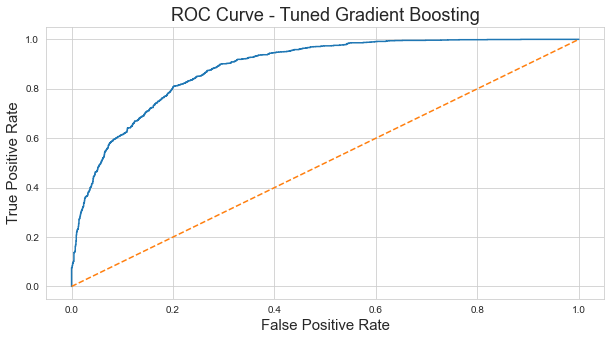

In [76]:
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC Curve - Tuned Gradient Boosting', fontsize=18)
plt.show()